In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import os

sns.set_theme(style="whitegrid")

FILENAME = 'plants.data'

In [3]:
def load_local_plants_data(filename):
    if not os.path.exists(filename):
        print(f"ОШИБКА: Файл '{filename}' не найден в текущей директории.")
        return None

    data_list = []
    all_locations = set()

    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        if not line:
            continue

        parts = line.split(',')
        if len(parts) > 1:
            plant_name = parts[0]
            locations = parts[1:]

            data_list.append({'plant': plant_name, 'locations': locations})
            all_locations.update(locations)

    print(f"Загружено растений: {len(data_list)}")
    print(f"Найдено уникальных регионов (признаков): {len(all_locations)}")

    sorted_locations = sorted(list(all_locations))
    location_to_idx = {loc: i for i, loc in enumerate(sorted_locations)}

    X_matrix = np.zeros((len(data_list), len(sorted_locations)), dtype=int)

    for i, item in enumerate(data_list):
        for loc in item['locations']:
            if loc in location_to_idx:
                X_matrix[i, location_to_idx[loc]] = 1

    df = pd.DataFrame(X_matrix, columns=sorted_locations)
    return df

Загружено растений: 34781
Найдено уникальных регионов (признаков): 70

--- 1: K-Means ---


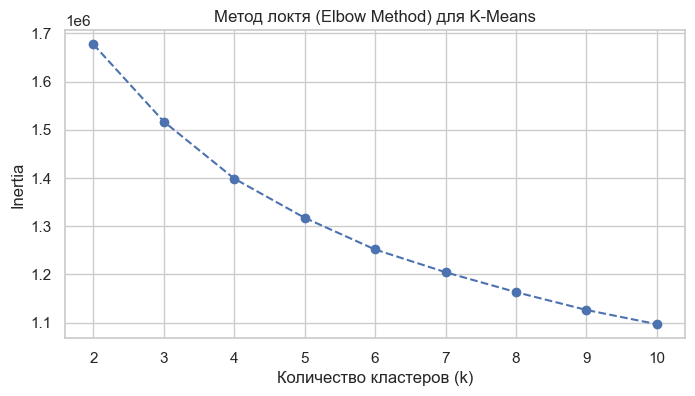


--- 2: Agglomerative Clustering ---

--- 3: DBSCAN ---

Графики кластеризации


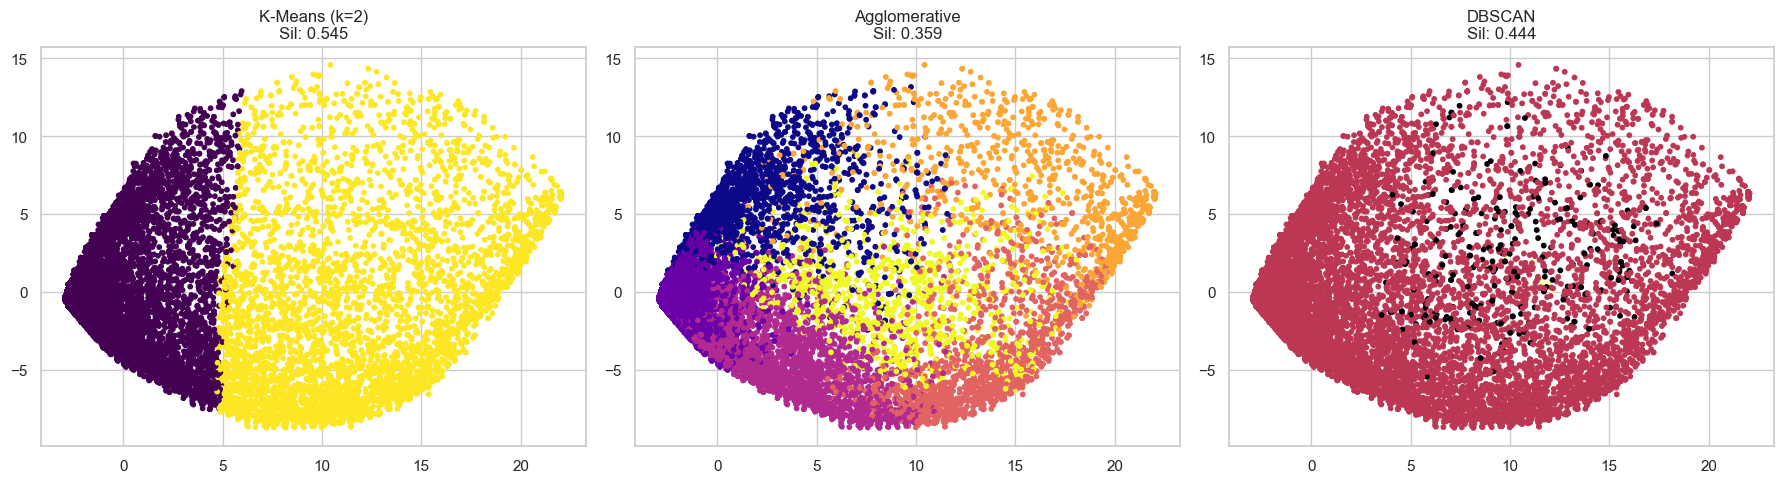


=== Результаты ===
    Algorithm Params  Silhouette
       KMeans    k=2    0.545305
       KMeans    k=3    0.485468
       DBSCAN eps=10    0.443650
       KMeans    k=4    0.393664
       DBSCAN  eps=8    0.374023
       DBSCAN  eps=7    0.363780
Agglomerative    k=6    0.358616
       KMeans    k=5    0.358286
Agglomerative    k=5    0.358083
Agglomerative    k=4    0.355443
       KMeans    k=6    0.346327
Agglomerative    k=3    0.346164
       KMeans    k=7    0.345907
       KMeans   k=10    0.146017
       KMeans    k=9    0.140245
       KMeans    k=8    0.139105
       DBSCAN  eps=5    0.080542
       DBSCAN  eps=3   -0.035365


In [ ]:
def main():
    # 1. Загрузка
    df = load_local_plants_data(FILENAME)

    if df is None:
        return

    # 2. Масштабирование
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    results_summary = []


    # 3. Алгоритм №1: K-MEANS
    print("\n--- 1: K-Means ---")
    inertia = []
    k_values = range(1, 11)

    best_km_k = 2
    best_km_score = -1
    best_km_labels = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)

        inertia.append(kmeans.inertia_)
        score = silhouette_score(X_scaled, labels)

        results_summary.append({
            'Algorithm': 'KMeans',
            'Params': f'k={k}',
            'Silhouette': score
        })

        if score > best_km_score:
            best_km_score = score
            best_km_k = k
            best_km_labels = labels

    plt.figure(figsize=(8, 4))
    plt.plot(k_values, inertia, marker='o', linestyle='--')
    plt.title('Метод локтя (Elbow Method) для K-Means')
    plt.xlabel('Количество кластеров (k)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

    # 4. Алгоритм №2: Agglomerative Clustering
    print("\n--- 2: Agglomerative Clustering ---")
    best_agg_score = -1
    best_agg_labels = []


    for k in [3, 4, 5, 6]:
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(X_scaled)

        score = silhouette_score(X_scaled, labels)
        results_summary.append({
            'Algorithm': 'Agglomerative',
            'Params': f'k={k}',
            'Silhouette': score
        })

        if score > best_agg_score:
            best_agg_score = score
            best_agg_labels = labels

    # 5. Алгоритм №3: DBSCAN
    print("\n--- 3: DBSCAN ---")

    best_db_score = -2
    best_db_labels = []

    eps_options = [3, 5, 7, 8, 10]

    for eps in eps_options:
        db = DBSCAN(eps=eps, min_samples=5)
        labels = db.fit_predict(X_scaled)

        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            score = silhouette_score(X_scaled, labels)
            results_summary.append({
                'Algorithm': 'DBSCAN',
                'Params': f'eps={eps}',
                'Silhouette': score
            })

            if score > best_db_score:
                best_db_score = score
                best_db_labels = labels
        else:
            print(f"  DBSCAN (eps={eps}): Кластеров не найдено (или только шум).")

    if len(best_db_labels) == 0:
        best_db_labels = np.zeros(len(df))
        print("  Внимание: DBSCAN не смог выделить кластеры с текущими параметрами.")

        # 6. Визуализация итогов
    print("\nГрафики кластеризации")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # KMeans Plot
    scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=best_km_labels, cmap='viridis', s=10)
    axes[0].set_title(f'K-Means (k={best_km_k})\nSil: {best_km_score:.3f}')

    # Agglomerative Plot
    scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=best_agg_labels, cmap='plasma', s=10)
    axes[1].set_title(f'Agglomerative\nSil: {best_agg_score:.3f}')

    # DBSCAN Plot
    scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=best_db_labels, cmap='inferno', s=10)
    axes[2].set_title(f'DBSCAN\nSil: {best_db_score:.3f}')

    plt.tight_layout()
    plt.show()


    # 7. Вывод сводной таблицы
    results_df = pd.DataFrame(results_summary)
    print("\n=== Результаты ===")
    if not results_df.empty:
        print(results_df.sort_values(by='Silhouette', ascending=False).to_string(index=False))
    else:
        print("Нет успешных результатов кластеризации.")


if __name__ == "__main__":
    main()